# Toy Example

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
# Data
# from survae.data.datasets.toy import TwoMoonsDataset, SineWaveDataset, CheckerboardDataset
from torch.utils.data import DataLoader, Dataset# Model
import torch
import torch.nn as nn
from survae.flows import Flow
from survae.distributions import StandardNormal


# Optim
from torch.optim import Adam

# Plot
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from survae.datasets.toy.plane import TwoMoonsDataset

In [7]:
n_train = 100_000
n_valid = 2_000
n_test = 100_000

ds_train = TwoMoonsDataset(num_points=n_train, noise=0.05, seed=123)
ds_valid = TwoMoonsDataset(num_points=n_valid, noise=0.05, seed=42)
ds_test = TwoMoonsDataset(num_points=n_test, noise=0.05, seed=666)


dl_train = DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=128, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=1_000, shuffle=False)

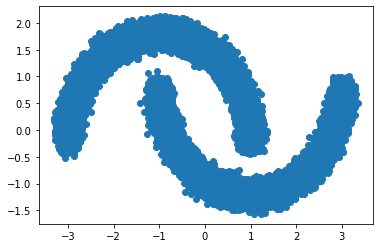

In [8]:
fig, ax = plt.subplots()

ax.scatter(ds_train[:][:, 0], ds_train[:][:, 1])
plt.show()

## Model

In [9]:
import torch.nn as nn
from survae.flows import Flow
from survae.distributions import StandardNormal
from survae.transforms import AffineCouplingBijection, ActNormBijection, BatchNormBijection, Reverse
from survae.transforms import RationalQuadraticSplineCouplingBijection
from survae.nn.layers import ElementwiseParams


# # NSF Model
# def net():
#     return nn.Sequential(nn.Linear(1, 128), nn.ReLU(),
#                        nn.Linear(128, 25), ElementwiseParams(25))

# model = Flow(
#     base_dist=StandardNormal((2,)),
#     transforms=[
#         AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AffineCouplingBijection(net()), ActNormBijection(2), Reverse(2),
#         AffineCouplingBijection(net()), ActNormBijection(2),
#     ])

# NSF Model
def net():
    return nn.Sequential(nn.Linear(1, 128), nn.ReLU(),
                       nn.Linear(128, 25), ElementwiseParams(25))

num_bins = 8

model = Flow(
    base_dist=StandardNormal((2,)),
    transforms=[
        RationalQuadraticSplineCouplingBijection(net(), num_bins), ActNormBijection(2), Reverse(2),
        RationalQuadraticSplineCouplingBijection(net(), num_bins), ActNormBijection(2), Reverse(2),
        RationalQuadraticSplineCouplingBijection(net(), num_bins), ActNormBijection(2), Reverse(2),
        RationalQuadraticSplineCouplingBijection(net(), num_bins), ActNormBijection(2), Reverse(2),
        RationalQuadraticSplineCouplingBijection(net(), num_bins), ActNormBijection(2), Reverse(2),
        RationalQuadraticSplineCouplingBijection(net(), num_bins), ActNormBijection(2),
    ])

In [10]:
# GF (Logistic Kernel CDF)
num_mixtures = 8
n_aug_dims = 4

from survae.distributions import StandardNormal
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, InverseGaussCDF
from survae.transforms.bijections.linear_orthogonal import FastHouseholder
from survae.transforms.surjections import Augment

# model = Flow(base_dist=StandardNormal((n_aug_dims,)),
#              transforms=[
#     Augment(StandardNormal((2,)), x_size=2),
#     GaussianMixtureCDF((n_aug_dims,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(n_aug_dims, 2),
#     GaussianMixtureCDF((n_aug_dims,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(n_aug_dims, 2),
#     GaussianMixtureCDF((n_aug_dims,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(n_aug_dims, 2),
#     GaussianMixtureCDF((n_aug_dims,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(n_aug_dims, 2),
#     GaussianMixtureCDF((n_aug_dims,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(n_aug_dims, 2),
#     GaussianMixtureCDF((n_aug_dims,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(n_aug_dims, 2),
#     GaussianMixtureCDF((n_aug_dims,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(n_aug_dims, 2),
#              ])

from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, LogisticMixtureCDF, SplineRQ

num_bins = 8
n_aug_dims = 2

model = Flow(
    base_dist=StandardNormal((n_aug_dims,)),
     transforms=[
         # Augment(StandardNormal((2,)), x_size=2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2), 
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2), 
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
         SplineRQ((n_aug_dims,), num_bins=num_bins), FastHouseholder(n_aug_dims, 2),
     ]
)

### Other Models

**Gaussianization Flows** (GFlow)

* Element-Wise: MixtureCDF, SplineRQ
* Linear: Permutation, Householder (Options: Fixed, Learned, Fast)

---
**GLOW**

* Coupling: Affine
* Linear: Householder (Options: Fixed, Learned, Fast)
* Normalization: ActNorm

---
**Neural Spline Flows** (NSF)

* Coupling: SplineRQ
* Linear: Householder (Options: Fixed, Learned, Fast)
* Normalization (Optional): ActNorm

---
**Flow++**

* Coupling: MixtureCDF + Logit + Affine
* Linear: Permutation, Householder (Options: Fixed, Learned, Fast)
* Normalization (Optional): ActNorm


In [29]:
from dataclasses import dataclass

In [31]:
@dataclass
class Flow:
    num_layers: int = 12
    # marginal gaussianization
    mg_layer: str = "splinerq" # Options: "splinerq", "mixgauss", "mixlogistic"
    num_bins: int = 8
    num_mixtures: int = 8
    eps: float = 1e-10
    max_iters: int = 100
    # inverse cdf layer
    inv_dist: str = "gauss"
    # linear (orthogonal) layer
    householder_fast: bool = True
    num_reflections: int = 2

In [ ]:
from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, InverseGaussCDF
from survae.transforms.bijections.linear_orthogonal import FastHouseholder, HouseholderSequence

def create_tabular_gflow(shape, config):

    transforms = list()


    for ilayer in trange(config.num_layers):
        
        
        # Element-Wise MARGINAL GAUSSIANIZATION LAYER
        if config.layer_mg == "splinerq":
            transforms.append(
                SplineRQ(shape, num_bins=config.num_bins)
            )
        elif config.layer_mg == "mixgauss":
            transforms.append(
                GaussianMixtureCDF(
                    input_shape=shape,
                    num_mixtures=config.num_mixtures,
                    eps=config.eps,
                    max_iters=config.max_iters,
                )
            )
        elif config.layer_mg == "mixlogistic":
            transforms.append(
                LogisticMixtureCDF(
                    input_shape=shape, 
                    num_mixtures=config.num_mixtures,
                    eps=config.eps,
                    max_iters=config.max_iters,
                )
            )
        else:
            raise ValueError(f"Unrecognized MG layer: {config.layer_mg}")
            
        # LINEAR (ORTHOGONAL) LAYER
        if not config.householder:
            
            
                
            
    
    return None

In [32]:
from survae.transforms.bijections.functional.householder import construct_householder_matrix, fast_householder_matrix

In [62]:
with torch.no_grad():
    num_dims = 100
    num_reflections = 2
    strides = 2
    v = torch.ones((num_dims, num_reflections))
    
    nn.init.orthogonal_(v)
    
    Q = construct_householder_matrix(v)
    Q_fast = fast_householder_matrix(v, strides)
    
    
torch.testing.assert_close(Q, Q_fast)

In [63]:
%timeit construct_householder_matrix(v)
%timeit fast_householder_matrix(v, 2)

877 µs ± 6.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
375 µs ± 2.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## MarkDown

In [11]:
# from survae.transforms import AffineCouplingBijection, ActNormBijection, Reverse
# from survae.transforms import LogisticMixtureCouplingBijection, RationalQuadraticSplineCouplingBijection, GaussianMixtureCouplingBijection
# from survae.transforms import Sigmoid, Logit
# from survae.transforms.bijections.elementwise_nonlinear import GaussianMixtureCDF, LogisticMixtureCDF, RQSplineCDF, InverseGaussCDF, KernelLogisticCDF
# from survae.transforms import Linear
# from survae.transforms.bijections.linear_orthogonal import LinearHouseholder, FastHouseholder
# from survae.transforms.bijections.conv1x1 import Conv1x1Householder
# from survae.nn.layers import ElementwiseParams

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, n_features), ElementwiseParams(n_features))

# # RealNVP Model
# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
#                AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
#                AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
#                AffineCouplingBijection(net(2)), ActNormBijection(2),
#              ])

# # Flow++ Model
# num_mixtures = 8
# num_params = 3 * num_mixtures

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, num_params), ElementwiseParams(num_params))

# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
#                Sigmoid(), LogisticMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(),
#              ])
# # model = Flow(base_dist=StandardNormal((2,)),
# #              transforms=[
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(), Reverse(2),
# #                GaussianMixtureCouplingBijection(net(2), num_mixtures=num_mixtures), Logit(),
# #              ])

# # Marginal GF (1 Layer)
# num_mixtures = 8
# num_params = 3 * num_mixtures

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, num_params), ElementwiseParams(num_params))

# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                 GaussianMixtureCDF((2,), num_mixtures=num_mixtures), Logit()
#              ])

# # GF (Logistic Mixture CDF)
# num_mixtures = 12


# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(), LinearHouseholder(2, 2),
#     LogisticMixtureCDF((2,), num_mixtures=num_mixtures), Logit(),
#              ])

# # GF (Logistic Mixture CDF)
# num_mixtures = 12


# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#     GaussianMixtureCDF((2,), num_mixtures=num_mixtures), InverseGaussCDF(), FastHouseholder(2, 2),
#              ])




# # GF (NSF)
# num_bins = 4
# num_layers = 12


# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2), 
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#                  RQSplineCDF((2,), num_bins=num_bins), LinearHouseholder(2, 2),
#              ])


# # NSF Model
# num_bins = 8
# num_params = 3 * num_bins + 1

# def net(n_features):
#     return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
#                        nn.Linear(200, 100), nn.ReLU(),
#                        nn.Linear(100, num_params), ElementwiseParams(num_params))
# model = Flow(base_dist=StandardNormal((2,)),
#              transforms=[
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(), Reverse(2),
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(), Reverse(2),
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(), Reverse(2),
#                Sigmoid(), RationalQuadraticSplineCouplingBijection(net(2), num_bins=num_bins), Logit(),
#              ])


### Demo Data

In [12]:
x_init = ds_train[:1_000]

loss = model.log_prob(x_init)


In [13]:
z, ldj = model.forward_transform(x_init)
x_approx = model.inverse_transform(z)



In [14]:
# torch.testing.assert_allclose(test_x, x_approx)

In [15]:
import corner

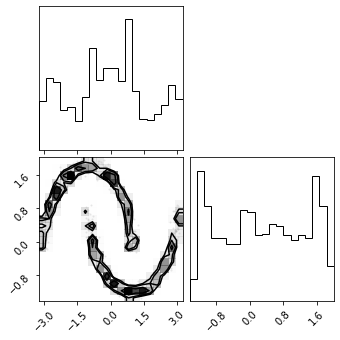

In [16]:
fig = corner.corner(x_init.detach().numpy())

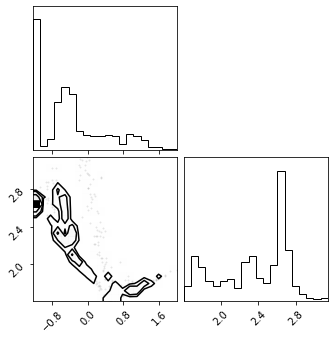

In [17]:
fig = corner.corner(z.detach().numpy())

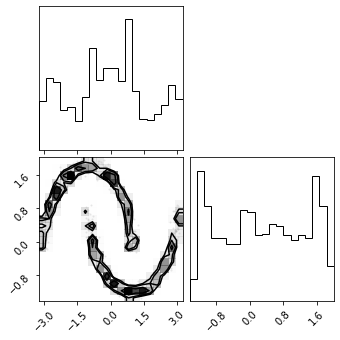

In [18]:
fig = corner.corner(x_approx.detach().numpy())

## Trainer

In [19]:
import pytorch_lightning as pl
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

class Learner2DPlane(pl.LightningModule):
    def __init__(self, model:nn.Module, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        # self.hyperparams = cast(Dict[str, Any], self.hparams)
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
                
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        self.log("loss", loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
                
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        self.log("val_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
                
        # loss function
        loss = -self.model.log_prob(batch).mean()
        
        self.log("test_loss", loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.model.parameters(), lr=self.hparams.get("lr", 1e-4))

        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer,
            warmup_epochs=self.hparams.get("warmup", 10),
            max_epochs=self.hparams.get("num_epochs", 300),
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [20]:
learning_rate = 1e-3
num_epochs = 500
warmup = 50
# initialize trainer
learn = Learner2DPlane(
    model,
    num_epochs=num_epochs,
    warmup=warmup,
    lr=learning_rate,
)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [21]:
n_epochs = 500

# initialize trainer
trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=num_epochs,
    accelerator="mps",
    # devices=1,
    enable_progress_bar=True,
    # logger=wandb_logger,
    # callbacks=callbacks,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(
    learn,
    train_dataloaders=dl_train,
    val_dataloaders=dl_valid
)


  | Name  | Type | Params
-------------------------------
0 | model | Flow | 700   
-------------------------------
700       Trainable params
0         Non-trainable params
700       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [23]:
results = trainer.test(learn, dataloaders=dl_test)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     1.771749496459961     │
└───────────────────────────┴───────────────────────────┘

## Latent Space

In [24]:
z_latent, ldj = learn.model.forward_transform(ds_test[:])

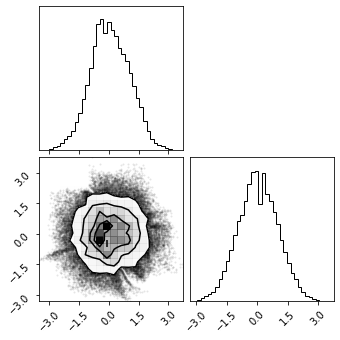

In [25]:
fig = corner.corner(z_latent.detach().numpy(), hist_bin_factor=2, )

### Likelihood

## Sampling

In [26]:
%%time
print('Sampling...')

samples = learn.model.sample(50_000).detach().numpy()

Sampling...
CPU times: user 657 ms, sys: 207 ms, total: 864 ms
Wall time: 263 ms


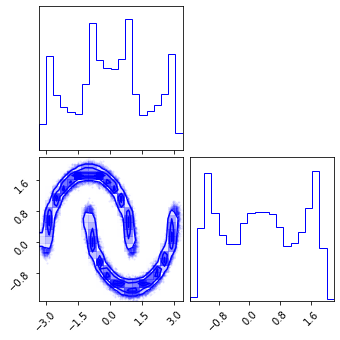

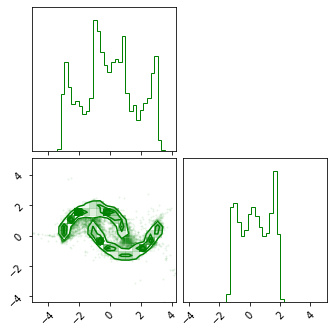

In [27]:
data = ds_test[:].detach().numpy()

fig = corner.corner(data, color="blue")


fig = corner.corner(samples, color="green", hist_bin_factor=2, )

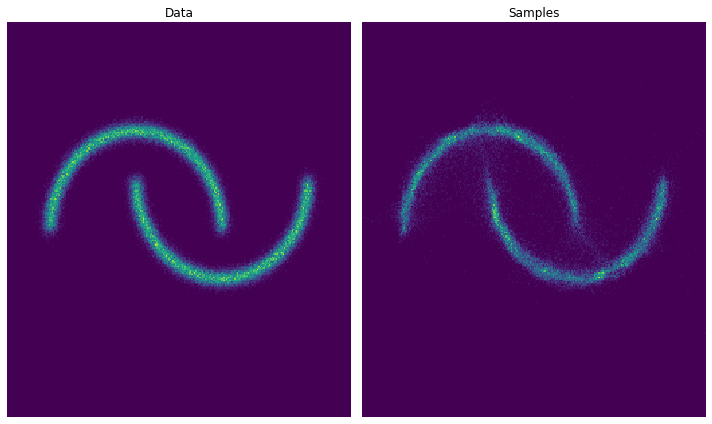

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].set_title('Data')
ax[0].hist2d(data[...,0], data[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[0].set_xlim([-4, 4]); ax[0].set_ylim([-4, 4]); ax[0].axis('off')
ax[1].set_title('Samples')
ax[1].hist2d(samples[...,0], samples[...,1], bins=256, range=[[-4, 4], [-4, 4]])
ax[1].set_xlim([-4, 4]); ax[1].set_ylim([-4, 4]); ax[1].axis('off')
plt.tight_layout()
plt.show()

